## Imports


In [1]:
import pandas as pd
import numpy as np
from numpy import random
import gensim
import nltk
from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from gensim.models import Word2Vec,KeyedVectors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from nltk.corpus import stopwords

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Exploring the data



In [3]:
import os
os.getcwd()

'C:\\Users\\Ruby\\Downloads\\transferlearning-v9isnmmkl5mr\\script\\notebookTL'

In [4]:
df = pd.read_csv(os.getcwd()+r'\..\data\tagged_plots_movielens.csv')
df = df.dropna()
df['plot'].apply(lambda x: len(x.split(' '))).sum()
df.head(3)

,Unnamed: 0,movieId,plot,tag
0,0,1,A little boy named Andy loves to be in his roo...,animation
1,1,2,When two kids find and play a magical board ga...,fantasy
2,2,3,Things don't seem to change much in Wabasha Co...,comedy


The dataset is only __170k__ words. It is quite small but makes sure we don't have to wait a long time for the code to complete.

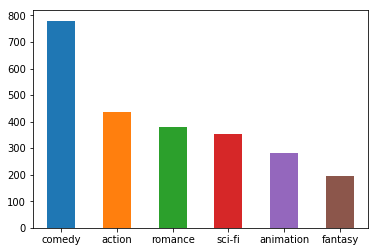

In [11]:
my_tags = ['sci-fi' , 'action', 'comedy', 'fantasy', 'animation', 'romance']
df.tag.value_counts().plot(kind="bar", rot=0)

In [12]:
train_data, test_data = train_test_split(df, test_size=0.1, random_state=42)

## Model evaluation

In [13]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')

In [15]:
def predict(vectorizer, classifier, data):
    data_features = vectorizer.transform(data['plot'])
    predictions = classifier.predict(data_features)
    target = data['tag']
    evaluate_prediction(predictions, target)

In [16]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [17]:
count_vectorizer = CountVectorizer(
    analyzer="word", tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english', max_features=3000) 
train_data_features = count_vectorizer.fit_transform(train_data['plot'])

accuracy 0.42386831275720166
confusion matrix
 [[21  2 10  1  4  4]
 [ 4 10  8  0  3  6]
 [10 11 45  4 15  1]
 [ 1  6  3  4  2  0]
 [ 1  3 15  2 11  3]
 [ 8  5  6  2  0 12]]
(row=expected, col=predicted)


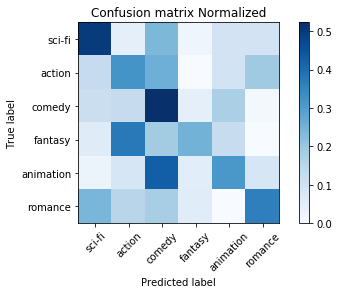

In [18]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tag'])
predict(count_vectorizer, logreg, test_data)

### TF-IDF

accuracy 0.46502057613168724
confusion matrix
 [[23  2 12  2  2  1]
 [ 3 10 10  1  3  4]
 [ 9  6 49  0 21  1]
 [ 3  4  1  4  2  2]
 [ 1  2 20  0 11  1]
 [ 9  2  5  1  0 16]]
(row=expected, col=predicted)


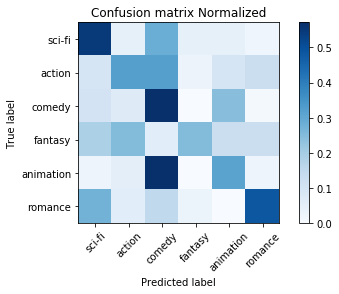

In [19]:
tf_vect = TfidfVectorizer(
    min_df=2, tokenizer=nltk.word_tokenize,
    preprocessor=None, stop_words='english')
train_data_features = tf_vect.fit_transform(train_data['plot'])

logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_data_features, train_data['tag'])
predict(tf_vect, logreg, test_data)

In [21]:
wv = KeyedVectors.load_word2vec_format(
    os.getcwd()+r"\..\data\GoogleNews-vectors-negative300.bin.gz",
    binary=True)
wv.init_sims(replace=True)

In [53]:

def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [88]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [50]:
test_tokenized = test_data.apply(lambda r: w2v_tokenize_text(r['plot']), axis=1).values
train_tokenized = train_data.apply(lambda r: w2v_tokenize_text(r['plot']), axis=1).values

In [54]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

CPU times: user 403 ms, sys: 5 µs, total: 403 ms
Wall time: 412 ms


In [55]:
knn_naive_dv = KNeighborsClassifier(n_neighbors=3, n_jobs=1, algorithm='brute', metric='cosine' )
knn_naive_dv.fit(X_train_word_average, train_data.tag)
predicted = knn_naive_dv.predict(X_test_word_average)
evaluate_prediction(predicted, test_data.tag)

CPU times: user 2.89 ms, sys: 998 µs, total: 3.89 ms
Wall time: 3.21 ms


In [94]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)

logreg = logreg.fit(X_train_word_average, train_data['tag'])
predicted = logreg.predict(X_test_word_average)
evaluate_prediction(predicted, test_data.tag)

CPU times: user 1.88 s, sys: 53.1 ms, total: 1.93 s
Wall time: 1.89 s


Great! It gives __54%__ accuracy. Best that we have seen so far.

# Doc2Vec

In [59]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [60]:
train_tagged = train_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r.tag]), axis=1)

In [61]:
test_tagged = test_data.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['plot']), tags=[r.tag]), axis=1)

This is what a training entry looks like - an example plot tagged by 'sci-fi'.

In [62]:
test_tagged.values[50]

TaggedDocument(words=['troubled', 'psychologist', 'is', 'sent', 'to', 'investigate', 'the', 'crew', 'of', 'an', 'isolated', 'research', 'station', 'orbiting', 'bizarre', 'planet'], tags=['sci-fi'])

In [141]:
trainsent = train_tagged.values
testsent = test_tagged.values

# simple gensim doc2vec api
doc2vec_model = Doc2Vec(trainsent, workers=1, size=5, iter=20, dm=1)

train_targets, train_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in trainsent])

2016-10-26 16:52:15,950 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2016-10-26 16:52:15,951 : INFO : collecting all words and their counts
2016-10-26 16:52:15,952 : INFO : PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
2016-10-26 16:52:16,037 : INFO : collected 17168 word types and 6 unique tags from a corpus of 2184 examples and 150640 words
2016-10-26 16:52:16,037 : INFO : Loading a fresh vocabulary
2016-10-26 16:52:16,061 : INFO : min_count=5 retains 3631 unique words (21% of original 17168, drops 13537)
2016-10-26 16:52:16,062 : INFO : min_count=5 leaves 128953 word corpus (85% of original 150640, drops 21687)
2016-10-26 16:52:16,078 : INFO : deleting the raw counts dictionary of 17168 items
2016-10-26 16:52:16,079 : INFO : sample=0 downsamples 0 most-common words
2016-10-26 16:52:16,080 : INFO : downsampling leaves estimated 128953 word corpus (100.0% of prior 128953)
2016-10-26 16:52:16,080 : INFO : estimated required

CPU times: user 7.53 s, sys: 59.8 ms, total: 7.59 s
Wall time: 7.49 s


In [150]:
test_targets, test_regressors = zip(
    *[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in testsent])

CPU times: user 344 ms, sys: 0 ns, total: 344 ms
Wall time: 344 ms


accuracy 0.38683127572
confusion matrix
 [[ 7  0 30  0  0  5]
 [ 3  0 21  0  0  7]
 [ 4  0 73  0  0  9]
 [ 1  0 14  0  0  1]
 [ 2  0 27  0  2  4]
 [ 6  0 15  0  0 12]]
(row=expected, col=predicted)


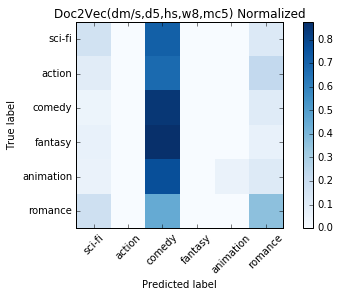

In [151]:
logreg = linear_model.LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(train_regressors, train_targets)
evaluate_prediction(logreg.predict(test_regressors), test_targets, title=str(doc2vec_model))